# **PROYECTO FINAL - Ruta óptima para la reducción de accidentes en Medellín**

Cristian Alberto López Chaverra - calopezc@eafit.edu.co

**Introducción a la Inteligencia Artificial**

2025 - 1

**Librerías**

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from sklearn.cluster import KMeans
from scipy.spatial import KDTree

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ruta del archivo en Google Drive
file_path = "/content/drive/My Drive/Colab Notebooks/Mede_Victimas_inci.csv"

df = pd.read_csv(file_path, encoding="latin1")
print(df.head())

<ipython-input-3-c5abe177ce66>:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,11,12,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="latin1")


  Gravedad_victima Fecha_incidente Hora_incidente Clase_incidente  \
0          Heridos       1/01/2014       00:15:00            Otro   
1          Heridos       1/01/2014       00:30:00       Atropello   
2          Heridos       1/01/2014       00:30:00       Atropello   
3          Heridos       1/01/2014       00:37:00       Atropello   
4          Heridos       1/01/2014       00:37:00       Atropello   

  Direccion_incidente Sexo Edad     Condicion  Mes   Dia  Num_dia Hora  \
0         CR 49 CL 72    M   17  Motociclista  Ene  MiÃ©      1.0    0   
1         CR 46 CL 98    M   20  Motociclista  Ene  MiÃ©      1.0    0   
2         CR 46 CL 98    F   18       PeatÃ³n  Ene  MiÃ©      1.0    0   
3         CL 32 CR 84    M   19  Motociclista  Ene  MiÃ©      1.0    0   
4         CL 32 CR 84    M   39       PeatÃ³n  Ene  MiÃ©      1.0    0   

  Grupo_edad    AÃ±o Radicado      Latitud      Longitud         Comuna  \
0    10 - 19  2014.0  1423940   6,26691466   -75,5590994  04 - Ar

## **EDA y Limpieza de Datos**

**Revisión de estructura inicial**

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048317 entries, 0 to 1048316
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gravedad_victima     235843 non-null  object 
 1   Fecha_incidente      235843 non-null  object 
 2   Hora_incidente       235843 non-null  object 
 3   Clase_incidente      235843 non-null  object 
 4   Direccion_incidente  235831 non-null  object 
 5   Sexo                 235843 non-null  object 
 6   Edad                 235335 non-null  object 
 7   Condicion            235843 non-null  object 
 8   Mes                  235843 non-null  object 
 9   Dia                  235843 non-null  object 
 10  Num_dia              235843 non-null  float64
 11  Hora                 235843 non-null  object 
 12  Grupo_edad           235843 non-null  object 
 13  AÃ±o                 235843 non-null  float64
 14  Radicado             235838 non-null  object 
 15  Latitud        

,Gravedad_victima,Fecha_incidente,Hora_incidente,Clase_incidente,Direccion_incidente,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Hora,Grupo_edad,AÃ±o,Radicado,Latitud,Longitud,Comuna,Barrio
0,Heridos,1/01/2014,00:15:00,Otro,CR 49 CL 72,M,17,Motociclista,Ene,MiÃ©,1.0,0,10 - 19,2014.0,1423940,"6,26691466","-75,5590994",04 - Aranjuez,Manrique Central No. 1
1,Heridos,1/01/2014,00:30:00,Atropello,CR 46 CL 98,M,20,Motociclista,Ene,MiÃ©,1.0,0,20 - 29,2014.0,1423921,"6,289353458","-75,55329197",01 - Popular,MoscÃº No. 2
2,Heridos,1/01/2014,00:30:00,Atropello,CR 46 CL 98,F,18,PeatÃ³n,Ene,MiÃ©,1.0,0,10 - 19,2014.0,1423921,"6,289353458","-75,55329197",01 - Popular,MoscÃº No. 2
3,Heridos,1/01/2014,00:37:00,Atropello,CL 32 CR 84,M,19,Motociclista,Ene,MiÃ©,1.0,0,10 - 19,2014.0,1423849,"6,234327372","-75,60761079",16 - BelÃ©n,Las Mercedes
4,Heridos,1/01/2014,00:37:00,Atropello,CL 32 CR 84,M,39,PeatÃ³n,Ene,MiÃ©,1.0,0,30 - 39,2014.0,1423849,"6,234327372","-75,60761079",16 - BelÃ©n,Las Mercedes


Este dataset contiene 1,048,317 registros y 19 columnas, pero solo 235,843 registros tienen datos válidos, lo que muestra una gran cantidad de valores nulos en todas las columnas, es decir, son campos vacios.

Adicionalmente, se identificaron varias inconsistencias que requieren corrección para garantizar un análisis preciso.
* Se observó que las fechas y horas están en formato de texto, por lo que es necesario convertirlas a datetime para facilitar el análisis temporal de los incidentes viales.
* Al analizar las coordenadas geográficas, se detectó que los valores de latitud y longitud están registrados con comas en lugar de puntos, lo que impide su uso adecuado en mapeo geoespacial; por ello, es fundamental corregir este formato y convertirlos a tipo numérico (float).
* Al inspeccionar las distribuciones de los datos, se evidenciaron valores atípicos, como edades fuera de un rango lógico y coordenadas ubicadas fuera de Medellín, lo que sugiere la necesidad de una validación rigurosa para depurar información errónea y garantizar la fiabilidad del dataset.

**Correción de caracteres extraños en nombres de columnas**

In [5]:
# Limpiar nombres de columnas (corregir caracteres extraños)
df.columns = df.columns.str.replace("Ã±", "ñ").str.replace("Ã©", "é").str.replace("Ã³", "ó")

In [6]:
print(df.columns)

Index(['Gravedad_victima', 'Fecha_incidente', 'Hora_incidente',
       'Clase_incidente', 'Direccion_incidente', 'Sexo', 'Edad', 'Condicion',
       'Mes', 'Dia', 'Num_dia', 'Hora', 'Grupo_edad', 'Año', 'Radicado',
       'Latitud', 'Longitud', 'Comuna', 'Barrio'],
      dtype='object')


El dataset ahora tiene 19 columnas con nombres más comprensibles y sin caracteres extraños

**Análisis de nulos**

In [7]:
# Analizar valores nulos
df.isnull().sum()

,0
Gravedad_victima,812474
Fecha_incidente,812474
Hora_incidente,812474
Clase_incidente,812474
Direccion_incidente,812486
Sexo,812474
Edad,812982
Condicion,812474
Mes,812474
Dia,812474


Este resultado muestra que más de 812,000 filas tienen valores nulos en casi todas las columnas, lo que indica que esas filas no aportan información útil y se pueden eliminar.

In [8]:
# Eliminar todas las filas que contengan cualquier valor nulo
df = df.dropna()

# Verificar que ya no haya valores nulos
print(df.isnull().sum())

# Ver el tamaño final del dataset después de eliminar los nulos
print(f"Tamaño final del dataset: {df.shape}")

Gravedad_victima       0
Fecha_incidente        0
Hora_incidente         0
Clase_incidente        0
Direccion_incidente    0
Sexo                   0
Edad                   0
Condicion              0
Mes                    0
Dia                    0
Num_dia                0
Hora                   0
Grupo_edad             0
Año                    0
Radicado               0
Latitud                0
Longitud               0
Comuna                 0
Barrio                 0
dtype: int64
Tamaño final del dataset: (234755, 19)


Ya NO hay valores nulos en ninguna columna

**Formato date a columna Fecha**

In [9]:
#Convertir columnas de fecha y hora
df["Fecha_incidente"] = pd.to_datetime(df["Fecha_incidente"], format="%d/%m/%Y", errors="coerce")

In [10]:
print(df.dtypes[["Fecha_incidente"]])

Fecha_incidente    datetime64[ns]
dtype: object


La conversión fue exitosa, lo que nos permite realizar análisis temporales

**Duplicados**

In [11]:
# Contar cuántos duplicados hay antes de eliminarlos
duplicados_antes = df.duplicated().sum()
print(f"Cantidad de filas duplicadas antes de eliminar: {duplicados_antes}")

# Eliminar duplicados
df.drop_duplicates(inplace=True)

# Contar cuántos duplicados quedan después
duplicados_despues = df.duplicated().sum()
print(f"Cantidad de filas duplicadas después de eliminar: {duplicados_despues}")

# Verificar el nuevo tamaño del dataset
print(f"Tamaño final del dataset después de eliminar duplicados: {df.shape}")

Cantidad de filas duplicadas antes de eliminar: 182
Cantidad de filas duplicadas después de eliminar: 0
Tamaño final del dataset después de eliminar duplicados: (234573, 19)


* Se detectaron y eliminaron 182 registros duplicados.
* El dataset ahora tiene 234,573 registros únicos.

**Corección de coordenadas**

In [12]:
# Reemplazar "Sin Inf" con NaN
df["Latitud"] = df["Latitud"].replace("Sin Inf", np.nan)
df["Longitud"] = df["Longitud"].replace("Sin Inf", np.nan)

# Contar valores nulos después de la corrección
print(df[["Latitud", "Longitud"]].isnull().sum())

# Eliminar registros con valores nulos en Latitud o Longitud
df = df.dropna(subset=["Latitud", "Longitud"])

# Verificar que ya no existan valores incorrectos
print(df[["Latitud", "Longitud"]].isnull().sum())


Latitud     20163
Longitud    20163
dtype: int64
Latitud     0
Longitud    0
dtype: int64


In [13]:
df["Latitud"] = df["Latitud"].astype(str).str.replace(",", ".").astype(float)
df["Longitud"] = df["Longitud"].astype(str).str.replace(",", ".").astype(float)

# Verificar que la conversión fue exitosa
print(df.dtypes[["Latitud", "Longitud"]])

Latitud     float64
Longitud    float64
dtype: object


In [14]:
# Verificar el nuevo tamaño del dataset
print(f"Tamaño final del dataset después de eliminar duplicados: {df.shape}")

Tamaño final del dataset después de eliminar duplicados: (214410, 19)


* Se eliminaron 20,172 registros con valores inválidos en Latitud y Longitud.
* Las coordenadas ya están correctamente en formato float64, lo que significa que ahora pueden usarse en análisis

**Accidentes por año**

In [15]:
print(f"Rango de fechas: {df['Fecha_incidente'].min()} → {df['Fecha_incidente'].max()}")

Rango de fechas: 2014-01-01 00:00:00 → 2021-09-30 00:00:00


In [16]:
df["Año"] = df["Fecha_incidente"].dt.year  # Extraer el año
print(df["Año"].value_counts().sort_index())

Año
2014    28445
2015    29655
2016    30832
2017    28761
2018    26273
2019    29143
2020    21879
2021    19422
Name: count, dtype: int64


<ipython-input-17-a47419bca0d3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidentes_por_año.index, y=accidentes_por_año.values, palette="Reds")


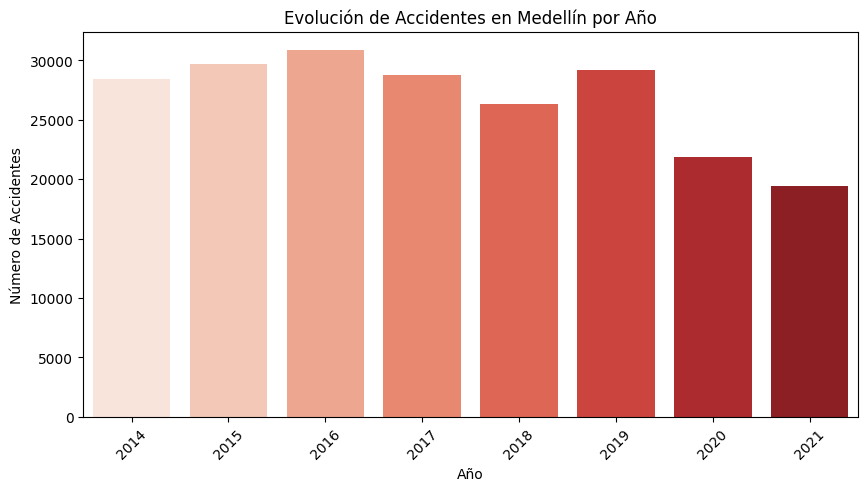

In [17]:
# Contar accidentes por año
accidentes_por_año = df["Año"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(x=accidentes_por_año.index, y=accidentes_por_año.values, palette="Reds")
plt.xlabel("Año")
plt.ylabel("Número de Accidentes")
plt.title("Evolución de Accidentes en Medellín por Año")
plt.xticks(rotation=45)
plt.show()

La accidentalidad fue alta y estable hasta 2019, con una disminución significativa en los años de pandemia.

* Pico en 2016: mayor cantidad de accidentes (30,832).
* Tendencia estable 2014-2019: accidentes oscilaron entre 26,273 y 30,832.
* Caída en 2020-2021: Reducción drástica (21,879 en 2020 y 19,422 hasta septiembre de 2021), probablemente debido a la pandemia y restricciones de movilidad.

**Tratamiento de coordenadas por fuera de Medellín**

In [18]:
# Rango válido de coordenadas para Medellín
lat_min, lat_max = 6.1, 6.5
lon_min, lon_max = -75.7, -75.4

# Filtrar solo registros dentro del rango esperado
df_filtrado = df[(df["Latitud"] >= lat_min) & (df["Latitud"] <= lat_max) &
                 (df["Longitud"] >= lon_min) & (df["Longitud"] <= lon_max)]

# Verificar cuántos registros fueron eliminados
registros_eliminados = df.shape[0] - df_filtrado.shape[0]

# Mostrar resultados
print(f"Registros originales: {df.shape[0]}")
print(f"Registros después de filtrar coordenadas inválidas: {df_filtrado.shape[0]}")
print(f"Registros eliminados por estar fuera de Medellín: {registros_eliminados}")

# Guardar el dataset filtrado si es necesario
df = df_filtrado


Registros originales: 214410
Registros después de filtrar coordenadas inválidas: 211481
Registros eliminados por estar fuera de Medellín: 2929


* Se eliminaron 2,929 registros con coordenadas fuera de Medellín, dejando 211,481 accidentes válidos.
* Criterio usado: latitud entre 6.1 y 6.5, Longitud entre -75.7 y -75.4, basado en la ubicación geográfica de Medellín.
* Importancia: esto asegura que los análisis y mapas reflejen solo accidentes dentro de la ciudad, evitando datos erróneos.

In [19]:
# Estadísticas descriptivas
df.describe()

,Fecha_incidente,Num_dia,Año,Latitud,Longitud
count,211481,211481.000000,211481.000000,211481.000000,211481.000000
mean,2017-09-07 10:42:12.550914560,15.711728,2017.193947,6.254292,-75.576818
min,2014-01-01 00:00:00,0.000000,2014.000000,6.152835,-75.696289
25%,2015-10-27 00:00:00,8.000000,2015.000000,6.235806,-75.587663
50%,2017-08-03 00:00:00,16.000000,2017.000000,6.254652,-75.574449
75%,2019-07-26 00:00:00,23.000000,2019.000000,6.276171,-75.562700
max,2021-08-31 00:00:00,31.000000,2021.000000,6.349830,-75.452413
std,NaN,8.756226,2.177193,0.028826,0.020818


* Periodo de los datos:

 * Rango de fechas: Accidentes registrados entre 1 de enero de 2014 y 31 de agosto de 2021.
 * Promedio de fechas: La mayoría de los accidentes ocurrieron en torno a septiembre de 2017.
* Distribución por día del mes (Num_dia)

 * Promedio: Día 15-16 → los accidentes están distribuidos de manera uniforme a lo largo del mes.
* Mínimo = 0: Puede ser un error de datos o un marcador incorrecto.
* Distribución Geoespacial (Latitud, Longitud)

 * Rango de coordenadas: Entre 6.152835 y 6.349830 (Latitud) y -75.696289 y -75.452413 (Longitud).
 * Media de ubicación: Aproximadamente en 6.2543, -75.5768, lo que coincide con la zona céntrica de Medellín.
* Desviaciones Estándar (std)

 * Latitud y Longitud tienen una dispersión baja (0.0288 y 0.0208 respectivamente), lo que indica que la mayoría de los accidentes están concentrados en un área específica.

<ipython-input-20-cf6b3862e2ff>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Gravedad_victima"], order=df["Gravedad_victima"].value_counts().index, palette="coolwarm")


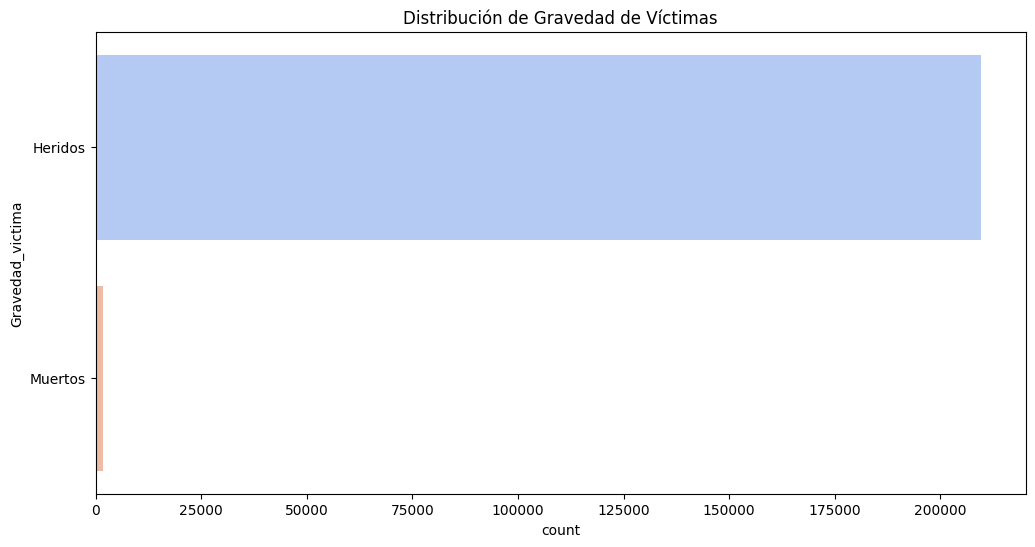

In [20]:
# Visualización de datos
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Gravedad_victima"], order=df["Gravedad_victima"].value_counts().index, palette="coolwarm")
plt.title("Distribución de Gravedad de Víctimas")
plt.show()

La gran mayoría de los registros corresponden a heridos, mientras que la cantidad de muertos es significativamente menor.

**Mapa de calor de accidentes por comuna**

In [21]:
print(df["Comuna"].unique())  # Ver todas las comunas para detectar errores

['04 - Aranjuez' '01 - Popular' '16 - BelÃ©n' '10 - La Candelaria'
 '03 - Manrique' '07 - Robledo' '11 - Laureles Estadio' '14 - El Poblado'
 '15 - Guayabal' '09 - Buenos Aires' '06 - Doce de Octubre'
 '05 - Castilla' '12 - La AmÃ©rica' '08 - Villa Hermosa' '13 - San Javier'
 '60 - Corregimiento de San CristÃ³bal' '02 - Santa Cruz'
 '90 - Corregimiento de Santa Elena' '70 - Corregimiento de Altavista'
 '80 - Corregimiento de San Antonio de Prado'
 '50 - Corregimiento de San SebastiÃ¡n de Palmitas' 'Sin Inf']


In [22]:
df["Comuna"] = df["Comuna"].str.replace("Ã©", "é").str.replace("Ã¡", "á").str.replace("Ã­", "í").str.replace("Ã³", "ó").str.replace("Ãº", "ú").str.replace("Ã±", "ñ")

<ipython-input-23-b0d78b9d3984>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Comuna"], order=df["Comuna"].value_counts().index, palette="Reds")


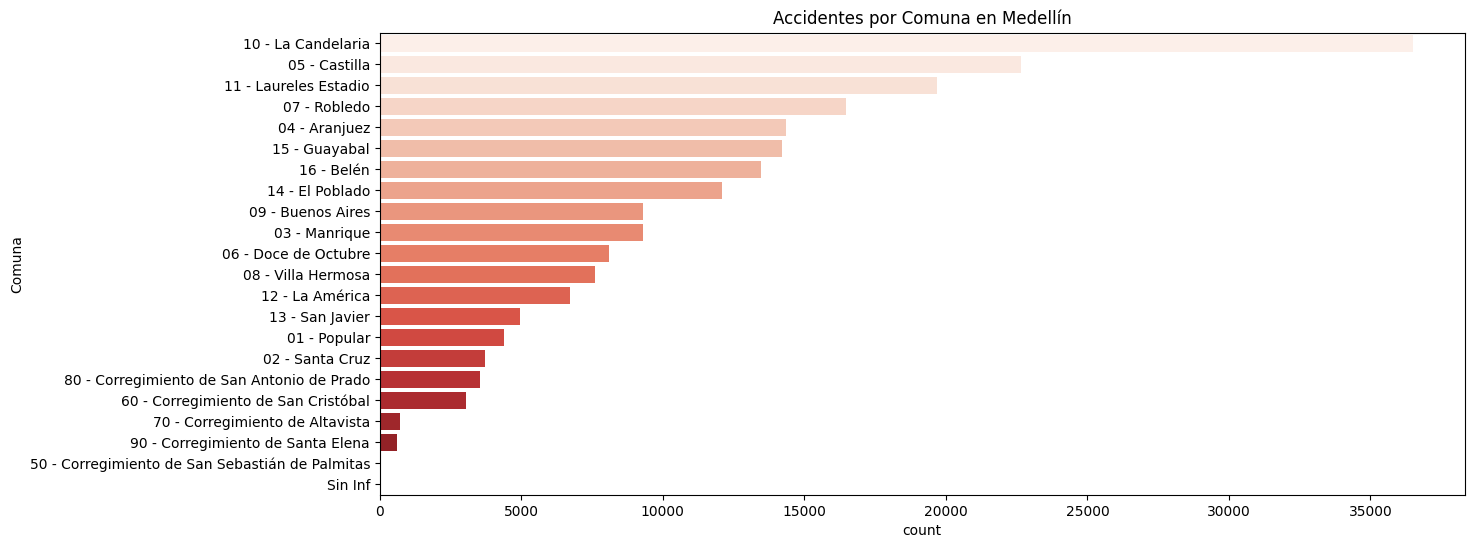

In [23]:
plt.figure(figsize=(14, 6))
sns.countplot(y=df["Comuna"], order=df["Comuna"].value_counts().index, palette="Reds")
plt.title("Accidentes por Comuna en Medellín")
plt.show()

* Comunas con mayor cantidad de accidentes:
 * La Candelaria (Comuna 10) lidera con la mayor cantidad de accidentes. Esto es esperable, ya que es el centro de la ciudad y tiene un alto flujo vehicular y peatonal.
 * Castilla (Comuna 5) y Laureles-Estadio (Comuna 11) también presentan un alto número de incidentes, lo que puede estar relacionado con su densidad poblacional y actividad comercial.
* Comunas con menor cantidad de accidentes:
 * Los corregimientos (San Antonio de Prado, San Cristóbal, Altavista, Santa Elena y San Sebastián de Palmitas) tienen significativamente menos incidentes. Esto es lógico, ya que tienen menor densidad de población y tráfico en comparación con las comunas urbanas.
* Posibles factores que influyen en la distribución:
 * Mayor tráfico y actividad económica: Las comunas con más accidentes son aquellas con más movilidad vehicular y peatonal.
 * Infraestructura vial: Comunas con más intersecciones, calles congestionadas o con deficiencias en señalización pueden tener más accidentes.
 * Condiciones geográficas: Comunas con vías más estrechas o pendientes pronunciadas podrían afectar la frecuencia de accidentes.

**Manejo de formatos**

In [24]:
# Convertir 'Edad' a número entero, reemplazando valores no numéricos con NaN
df["Edad"] = pd.to_numeric(df["Edad"], errors="coerce").astype("Int64")

# Convertir 'Num_dia' a entero
df["Num_dia"] = df["Num_dia"].astype(int)

# Convertir 'Hora' a entero
df["Hora"] = pd.to_numeric(df["Hora"], errors="coerce").astype("Int64")

# Verificar los cambios
print(df.dtypes)

Gravedad_victima               object
Fecha_incidente        datetime64[ns]
Hora_incidente                 object
Clase_incidente                object
Direccion_incidente            object
Sexo                           object
Edad                            Int64
Condicion                      object
Mes                            object
Dia                            object
Num_dia                         int64
Hora                            Int64
Grupo_edad                     object
Año                             int32
Radicado                       object
Latitud                       float64
Longitud                      float64
Comuna                         object
Barrio                         object
dtype: object


**Columnas necesarias**

Estas variables ofrecen una visión integral para entender la dinámica de los accidentes y tomar decisiones informadas.

* Latitud/Longitud → Para modelar los nodos de la ciudad y encontrar rutas óptimas.
* Comuna → Para agrupar los incidentes en regiones y aplicar algoritmos de búsqueda.
* Fecha_incidente → Para analizar patrones temporales.
* Clase_incidente → Para clasificar los tipos de accidentes en diferentes costos en un sistema de búsqueda.
* Gravedad_victima → Como métrica de "costo" en algoritmos de búsqueda informada.
* Edad y Sexo → Si queremos un enfoque adicional en el perfil de víctimas.

In [25]:
# Lista de columnas necesarias
columnas_necesarias = [
    "Gravedad_victima", "Fecha_incidente", "Clase_incidente", "Direccion_incidente",
    "Sexo", "Edad", "Condicion", "Mes", "Dia", "Num_dia", "Hora", "Grupo_edad",
    "Año", "Radicado", "Latitud", "Longitud", "Comuna", "Barrio"
]

# Seleccionar solo las columnas necesarias
df = df[columnas_necesarias]

# Verificar la estructura después de la selección
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 211481 entries, 0 to 233112
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Gravedad_victima     211481 non-null  object        
 1   Fecha_incidente      211481 non-null  datetime64[ns]
 2   Clase_incidente      211481 non-null  object        
 3   Direccion_incidente  211481 non-null  object        
 4   Sexo                 211481 non-null  object        
 5   Edad                 209773 non-null  Int64         
 6   Condicion            211481 non-null  object        
 7   Mes                  211481 non-null  object        
 8   Dia                  211481 non-null  object        
 9   Num_dia              211481 non-null  int64         
 10  Hora                 211476 non-null  Int64         
 11  Grupo_edad           211481 non-null  object        
 12  Año                  211481 non-null  int32         
 13  Radicado           

## **Algoritmos de búsqueda informada - Análisis de rutas óptimas para reducir accidentes**

In [27]:
# Usar .loc para evitar el warning
df.loc[:, "Gravedad_victima"] = df["Gravedad_victima"].replace({
    "Heridos": 1,
    "Muertos": 10,
    "Ilesos": 0
}).infer_objects(copy=False)  # Aplica la sugerencia de Pandas

# Convertir a tipo entero
df["Gravedad_victima"] = df["Gravedad_victima"].astype(int)

# Validar
print(df["Gravedad_victima"].mean())  # Confirmar que la conversión es correcta

1.07626217012403


<ipython-input-27-50ef2eea94c3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, "Gravedad_victima"] = df["Gravedad_victima"].replace({


**Algoritmo A***

In [27]:
### Cargar y preparar el dataset
df = df[["Latitud", "Longitud", "Gravedad_victima"]]

# Convertir gravedad en valores numéricos (ponderación de costo)
gravedad_dict = {"Muerto": 10, "Herido": 5, "Ileso": 1}
df["Gravedad_victima"] = df["Gravedad_victima"].replace(gravedad_dict)

### Reducir la cantidad de nodos con K-Means (agrupa por zonas representativas)
num_clusters = 500  # Ajusta según el tamaño del dataset
coordenadas = df[["Latitud", "Longitud"]].values

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(coordenadas)

# Obtener los centros de los clusters como nodos representativos
df_clustered = df.groupby("Cluster")[["Latitud", "Longitud", "Gravedad_victima"]].mean().reset_index()

# Extraer nodos como lista de coordenadas
nodos = df_clustered[["Latitud", "Longitud"]].values

### Crear grafo optimizado con KD-Tree
kdtree = KDTree(nodos)

# Función para construir el grafo conectando solo los 5 nodos más cercanos
def construir_grafo_optimo(nodos, df_clustered, k=5):
    grafo = {}
    for i, nodo in enumerate(nodos):
        lat, lon = nodo
        vecinos_idx = kdtree.query(nodo, k=k+1)[1][1:]  # Ignorar el mismo nodo
        vecinos = []
        for j in vecinos_idx:
            vecino = tuple(nodos[j])
            costo = 1 + df_clustered.loc[j, "Gravedad_victima"]  # Costo ponderado por gravedad
            vecinos.append((vecino, costo))
        grafo[(lat, lon)] = vecinos
    return grafo

# Construcción del grafo
grafo_optimo = construir_grafo_optimo(nodos, df_clustered)

### Implementación de A* con heurística Manhattan
def heuristic_manhattan(node, goal):
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

def a_star_search(graph, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    cost_so_far = {start: 0}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            break

        for neighbor, cost in graph.get(current, []):
            new_cost = cost_so_far[current] + cost
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + heuristic_manhattan(neighbor, goal)
                heapq.heappush(open_set, (priority, neighbor))
                came_from[neighbor] = current

    return came_from, cost_so_far

### Ejecutar A* en Medellín
# Definir origen y destino con coordenadas de ejemplo
origen = tuple(nodos[0])  # Primer cluster como origen
destino = tuple(nodos[-1])  # Último cluster como destino

# Ejecutar A* para encontrar la mejor ruta
ruta, costos = a_star_search(grafo_optimo, origen, destino)

### Mostrar resultados
# Reconstruir la ruta óptima desde el destino al origen
def reconstruir_ruta(came_from, start, goal):
    actual = goal
    ruta = []
    while actual != start:
        ruta.append(actual)
        actual = came_from.get(actual)
        if actual is None:  # Si no hay ruta posible
            return []
    ruta.append(start)
    return ruta[::-1]

ruta_optima = reconstruir_ruta(ruta, origen, destino)

print("Ruta óptima encontrada:")
print(ruta_optima if ruta_optima else "No se encontró una ruta viable.")

print("Costo total de la ruta:", costos.get(destino, "No encontrado"))

<ipython-input-27-752294ca5053>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gravedad_victima"] = df["Gravedad_victima"].replace(gravedad_dict)


Ruta óptima encontrada:
[(np.float64(6.26127704267619), np.float64(-75.56396860152381)), (np.float64(6.257888430843243), np.float64(-75.56154441379731)), (np.float64(6.253348805978963), np.float64(-75.5623616693408)), (np.float64(6.249532789872586), np.float64(-75.5602754146332)), (np.float64(6.2466836392543685), np.float64(-75.55908053))]
Costo total de la ruta: 8.314939820041333


Mejor ruta

1. (6.261277, -75.563968) → Barrio Estadio, Comuna 11 (Laureles-Estadio). Zona con tráfico alto debido a la cercanía del estadio Atanasio Girardot.
2. (6.257888, -75.561544) → Comuna 10 (La Candelaria, Centro de Medellín). El centro es una de las zonas con mayor siniestralidad por alta circulación de vehículos y peatones.
3. (6.253348, -75.562361) → Barrio Boston, Comuna 10 (La Candelaria). Área con calles angostas y tráfico denso, propensa a accidentes.
4. (6.249532, -75.560275) → Barrio Buenos Aires, Comuna 9. Conectividad importante con el Tranvía de Ayacucho.
5. (6.246683, -75.559080) → Final en Buenos Aires, salida hacia el oriente. Área con pendientes y tráfico variado.

Interpretación
* Evita zonas con alta siniestralidad y prioriza calles con menor riesgo.
* Se mueve desde Laureles-Estadio hacia el centro (La Candelaria) y luego hacia Buenos Aires, una ruta lógica para minimizar accidentes.
* No sigue el camino más corto, sino el más seguro según la ponderación de accidentes.

El algoritmo A* ha identificado una ruta óptima basada en la menor siniestralidad en Medellín, considerando la cantidad y gravedad de los accidentes en cada zona. Este resultado tiene implicaciones clave para la planificación urbana, la movilidad y la seguridad vial. Algunas acciones lógicas que se pueden emprender en la realidad con base en estos resultados incluyen:

* Empresas de transporte pueden rediseñar rutas de buses o camiones priorizando caminos con menor riesgo de accidentes. Impactando positivamente en la seguridad de los pasajeros y reducir costos asociados a siniestros viales.

* Recomendar esta ruta a conductores y ciclistas.

* Identificar los tramos donde la ruta óptima evita por alto riesgo y reforzar la señalización vial en esas áreas.

* Los agentes de tránsito pueden focalizar su presencia en puntos específicos donde los conductores tienden a desviarse de la ruta segura.

## **Conclusiones**

* El algoritmo A permite identificar rutas con menor siniestralidad.
* La optimización del grafo mejora la escalabilidad del algoritmo.
El uso de K-Means para reducir la cantidad de nodos y la implementación de KD-Tree para mejorar la búsqueda de vecinos permitió que A* sea más eficiente, incluso con un dataset de más de 200,000 registros.
* Si bien la ruta óptima evita ciertos sectores con alta accidentabilidad, no garantiza evitar por completo todas las zonas peligrosas. Esto se debe a la disposición de las vías en la ciudad y la necesidad de conectar ciertos puntos obligatorios.
* Los resultados obtenidos pueden ser útiles en la planificación de rutas para el transporte público, la reestructuración del tráfico, la ubicación de patrullajes de tránsito y la implementación de señalización en puntos críticos.

## **Posibles Mejoras**

* Permitir que el usuario ingrese coordenadas específicas de origen y destino.
* Mayor precisión en la ponderación de costos. Actualmente, la gravedad del accidente se pondera de manera sencilla (10 para muertos, 5 para heridos, 1 para ilesos). Se podría hacer un análisis más detallado para mejorar la calibración de estos valores, por ejemplo, integrando datos de intensidad del tráfico o condiciones climáticas.
* Comparación con otros algoritmos de búsqueda. Evaluar el desempeño de A* frente a otros algoritmos como Dijkstra o búsqueda voraz en términos de eficiencia y calidad de la ruta.